In [1]:
# Initial Code source by:                Gaël Varoquaux
#                                        Andreas Müller
# Modified for documentation by:         Jaques Grobler
# Mainly Modified for private usage by:  Ioannis Agriomallos
#                                        Ioanna Mitsioni
# License: BSD 3 clause
####################################################################################################################
######==================== CURRENT CODE USAGE ======================================================================
# -> Current code trains several ML Classifiers, to classify force input samples as stable (0) or slip (1)
######---- Input
# -> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 3 different datasets, 
# containing several surfaces as well as slip-stable occurrences
######---- Input transformation
# -> Several pre-features are taken from these inputs.
# -> Several time and frequency domain features are extracted from pre-feature windows. 
# (implemented in 'newfeatext.py') These windows have size w and are shifted by s on each sample
# -> Then a feature selection-ranking is performed using MutualVariableInformation
# -> Finally PCA is performed to keep the desired among the best selected features
######---- Training of ML Classifiers
# -> Several ML Classifiers are trained for all combinations of features-datasets
######---- Stats report
# -> Several stats are reported on the classification results of the trained models, 
# based on their accuracy (fscore and auc as well) on test data as well as previously unseen data
######===================== POTENTIAL CODE EXTENSION FOR FURTHER MORE GENERIC USAGE ================================
# -> As binary classification problem it may apply to all such problems given that:
######----- Input
# -> Input is loaded on datasets, which expect (n,1) input with (k,4) dimensions each,
# where n data samples, k measurement in each sample, 3 force readings and 1 label for each measurement.
######----- Input transformation
# -> Pre-features must be changed or ommitted to fit your needs. 
# Here they served to transform the 3 (fx,fy,fz) force readings into one between (ft,fn,ft/fn,sf)
# -> Features are performed on the desired pre-features. They take a (n,o,m) input matrix and return a (n,o,l),
# where n data samples, o windows, m prefeatures, l features.
# -> Feature selection gives a ranking on each l, so we keep b from the best
# -> PCA is performed on the b selected features resulting in p dimensions (n,o,p) => (n*o,p)
######----- Training of ML Classifiers
# -> Each Classifier is trained on a subset of (n*o,p)
######----- Stats
# -> Change accordingly!
####################################################################################################################
print(__doc__)
import time
start_time = time.time()
from copy import deepcopy, copy
import math
import scipy.io as sio
import shutil
import os, errno
from random import shuffle
import numpy as np
from pylab import *
from featext2 import *
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib qt
# inline (suitable for ipython only, shown inside browser!) or qt (suitable in general, shown in external window!)
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D #, axes3d
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, ParameterGrid, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RandomizedLasso
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif, SelectFdr
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from collections import OrderedDict
import re
import datetime
import urllib
import tarfile
import joblib
from joblib import Parallel, delayed, Memory
from tempfile import mkdtemp
import copy_reg
import types
import itertools
import pywt
from scipy import signal
from scipy.signal import lfilter, butter
from numpy.fft import fft, fftfreq, rfft

#import multiprocessing
def _pickle_method(m):
    if m.im_self is None:
        return getattr, (m.im_class, m.im_func.func_name)
    else:
        return getattr, (m.im_self, m.im_func.func_name)
copy_reg.pickle(types.MethodType, _pickle_method)

def ensure_dir(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
datapath = 'tmp/'
featpath = datapath+'features/'
ensure_dir(datapath)
ensure_dir(featpath)
            
h = .2  # step size in the mesh

names = ["NearNb", "RBFSVM1", "MLP1", "RandFor"]
classifiers = [KNeighborsClassifier(5),
               SVC(gamma='auto', C=1),
               MLPClassifier(solver='lbfgs',alpha=1e-4,hidden_layer_sizes=(10,10),random_state=1,verbose=True),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)]

cv = StratifiedKFold(n_splits=5, random_state=42)

parameters_clf = [{'n_neighbors':[4,7,9,12]},
                  {'kernel':['rbf'], 'C':[0.1,10,100,1000]},
                  {'solver':['lbfgs'], 'alpha':[1e-5,1e-2], 'hidden_layer_sizes':[(10,10),(50,50)]},
                  {'max_depth':[4,7,10,20],'n_estimators':[5,10,20],'max_features':[20,35,50]}]
makepipe_parameters_clf = [{'classifier__'+key:p[key] for key in p} for p in parameters_clf]
makepipe_parameters_clf += [{'feature_selection__k': (750,500,100), 'feature_selection__score_func': [mutual_info_classif]},
                            {'decomp__n_components': (100,50)}]

metric = ['accuracy','f1']
dataset = 0 # all datasets (0), dataset 1-2 (1), dataset 3 (2), dataset4 (3)
download = 1 # Download pre-computed (1) data or compute them anew (0)

Automatically created module for IPython interactive environment


In [2]:
######################################## INITIALISATION PARAMETERS #################################################
window, shift, keepfromshift = 1024, 20, 10
samplesperdataset = 10000
havelabel = 1
returntime = 0
featlabel = 0         # 0: all features, 1: temporal, 2: frequency, 3: FFT only
magnFFT = 0           # 0: FFT in magnitude format, 1: FFT in real and imag format, 
featall = 0           # 0: all, 1: feat1 (phinyomark's), 2: feat2 (golz's)
featparam = [havelabel,featlabel,magnFFT,featall,returntime]
metr = metric[0]      # 0: accuracy, 1: f1score
CV = 5                # cross validation checks
datapath = 'tmp/'
featpath = datapath+'features/'+str(window)+'_'+str(shift)+'/'
ensure_dir(featpath)
numfeat = 10 # number of features to show
nfeat = 1000 # number of features to keep

In [3]:
########################################## Download necessary files ################################################
# if download==1:
#     downpath = featpath
#     downfile = downpath+"features.tar.gz"
#     downlink = "https://www.dropbox.com/s/lx3ggezzq2wl2km/features.tar.gz?dl=1"
#     if not os.path.isfile(downfile):
#         u = urllib.urlopen(downlink)
#         data = u.read()
#         print 'Completed downloading ',len(data)*1./(1024**3),'GB of ',downfile,'!'
#         u.close()
#         with open(downfile, "wb") as f :
#             f.write(data)
#     else:
#         print 'Necessary ',downfile,'  already here!'
#     print 'Extracting files...'
#     directory = featpath
#     def extract_nonexisting(archive):
#         for name in archive.getnames():
#             if os.path.exists(os.path.join(directory, name)):
#                 print name, "already exists"
#             else:
#                 archive.extract(name, path=directory)
#     archives = [name for name in os.listdir(directory) if name.endswith("tar.gz")]
#     for archive_name in archives:
#         with tarfile.open(featpath+archive_name) as archive:
#             extract_nonexisting(archive)
# #     if (downfile.endswith("tar.gz")):
# #         tar = tarfile.open(downfile, "r:gz")
# #         tar.extractall(path=downpath)
# #         tar.close()
#     print 'Completed extracting files!'
########################################## Download necessary dataset #############################################
datafile = datapath+'dataset.npz'
if not os.path.isfile(datafile):
#     downdata = "https://www.dropbox.com/s/95znajbu6sga8iz/slipdataset3_C.mat?dl=1"
#     u = urllib.urlopen(downdata)
#     data = u.read()
#     print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',datafile,'!'
#     u.close()
#     with open(datafile, "wb") as f :
#         f.write(data)
    print 'Necessary ',datafile,' not here! DO SOMETHING ABOUT IT!'
else:
    print 'Necessary ',datafile,' already here!'


########################################## Initialize Feature names and paths #####################################

featname = 'features'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
featfile = featpath+featname+'.npz'
XYfile = featpath+featname+'_XY.npz'
XYsplitfile = featpath+featname+'_XYsplit.npz'

Necessary  tmp/dataset.npz  already here!


In [4]:
########################################## READ THE DATASET #######################################################
# ################ DATASET, from each of the 2 fingers for all 6 surfaces (see fd for details) #############
inp = np.load(datafile)
f = inp['f']
l = inp['l']
fd = inp['fd']
print 1,f.shape,l.shape,fd.shape
# membership of each sample, representing its portion in the dataset (first half finger1 and second half finger2)
member = np.zeros(len(f))
m1,m2 = len(f)/2, len(f)/2
member[:m1] = np.ones(m1)*1./m1
member[-m2:] = np.ones(m2)*1./m2
print 2,m1,m2,sum(member[:m1]),sum(member[-m2:])
########################################### MERGE f and l ##########################################################
f = np.array([np.concatenate((f[i],l[i][:,np.newaxis]),axis=1) for i in range(len(f))])
print 3,f.shape,":",[fi.shape for fi in f]
########################################### SUBSAMPLING ############################################################
step = 1 # NO SAMPLING
f = np.array([fi[::step,:] for fi in f])
print 4,f.shape,":",[fi.shape for fi in f]

1 (72,) (72,) (72, 4)
2 36 36 1.0 1.0
3 (72,) : [(345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (130001, 4), (195001, 4), (65001, 4), (345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (130001, 4), (195001, 4), (65001, 4)]
4 (72,) : [(345002, 4), (105001, 4), 

In [5]:
###########################################################################################
def make_pipe_clf(scaler,feature_selection,decomp,clf):
    # first normalize, then perform feature selection, followed by PCA and finally the desired classifier.
    pipeline = Pipeline([('scaler', scaler),
                         ('feature_selection', feature_selection),
                         ('decomp', decomp),         
                         ('classifier', clf) ])
    return pipeline
###########################################################################################
def make_pipe(scaler,feature_selection,decomp,order):
    # first normalize, then perform feature selection, followed by PCA. 
    pipeline = Pipeline([('scaler', scaler),
                         ('feature_selection', feature_selection),
                         ('decomp', decomp) ])
    return pipeline

In [6]:
def gs_fun(clf,params,cv,x,y):
    grid_search = GridSearchCV(estimator=clf,param_grid= params, cv = cv, n_jobs=-1, verbose = 0)
    grid_search.fit(x,y)
    print("------ Grid search cv results for %0.8s ------" %clf)
    print("Best score: %0.4f" %grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
         print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return best_parameters, grid_search.best_estimator_

In [7]:
########################################### PRE-FEATURES ###########################################################
############# DEFINITION
# featnum 0 : sf    = (fx^2+fy^2+fz^2)^0.5
#         1 : ft    = (fx^2+fy^2)^0.5
#         2 : fn    = |fz|
#         3 : ft/fn = (fx^2+fy^2)^0.5/|fz|
# input (nxm) -> keep (nx3) -> compute pre-feature and return (nx1)

def sf(f):
    return np.power(np.sum(np.power(f[:,:3],2),axis=1),0.5)
def ft(f):
    return np.power(np.sum(np.power(f[:,:2],2),axis=1),0.5)
def fn(f):
    return np.abs(f[:,2])
def ftn(f):
    retft = ft(f)
    retfn = fn(f)
    retft[retfn<=1e-2] = 0
    return np.divide(retft,retfn+np.finfo(float).eps)
def lab(f):
    return np.abs(f[:,-1])
prefeatfn = np.array([sf,ft,fn,ftn,lab]) # convert to np.array to be easily indexed by a list
prefeatid = [0,4]   # only the prefeatures with corresponding ids will be computed

############# COMPUTATION
prefeatname = 'prefeatures'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
prefeatfile = featpath+prefeatname+'.npz'

prefeat = np.array([np.array([prfn(f[i]) for prfn in prefeatfn[prefeatid]]).transpose() for i in range(len(f))])
print prefeat.shape,":",[p.shape for p in prefeat]

(72,) : [(345002, 2), (105001, 2), (210001, 2), (225002, 2), (130001, 2), (65001, 2), (195001, 2), (65001, 2), (130001, 2), (195001, 2), (65001, 2), (130001, 2), (225002, 2), (65001, 2), (130001, 2), (195001, 2), (65001, 2), (130001, 2), (75001, 2), (130001, 2), (195001, 2), (195001, 2), (130001, 2), (65001, 2), (65001, 2), (130001, 2), (195001, 2), (195001, 2), (130001, 2), (65001, 2), (65001, 2), (130001, 2), (195001, 2), (130001, 2), (195001, 2), (65001, 2), (345002, 2), (105001, 2), (210001, 2), (225002, 2), (130001, 2), (65001, 2), (195001, 2), (65001, 2), (130001, 2), (195001, 2), (65001, 2), (130001, 2), (225002, 2), (65001, 2), (130001, 2), (195001, 2), (65001, 2), (130001, 2), (75001, 2), (130001, 2), (195001, 2), (195001, 2), (130001, 2), (65001, 2), (65001, 2), (130001, 2), (195001, 2), (195001, 2), (130001, 2), (65001, 2), (65001, 2), (130001, 2), (195001, 2), (130001, 2), (195001, 2), (65001, 2)]


In [8]:
############# PLOT one force sample from dataset and the corresponding Prefeature normalized
# i = -1 # take the laste sample set
# print prefeat[i].shape
# plt.subplot(2,1,1)
# plt.plot(prefeat[i]/np.max(prefeat[i],axis=0))
# plt.subplot(2,1,2)
# plt.plot((f[i]-np.min(f[i],axis=0))/(np.max(f[i],axis=0)-np.min(f[i],axis=0)))

In [9]:
############################# AVG Computation time of ALL features in secs ########################################
t1 = time.time()
tmpfeat = [feat(prefeat[k][i:i+window,:2],*featparam) for k in range(20) for i in range(100)] # avg over 20*100 times
print 'Avg feature computation time (millisec): ', (time.time()-t1)/(100*20)*1000

Avg feature computation time (millisec):  2.00435447693


In [10]:
############################################# FEATURE COMPUTATION ##################################################
def tmpfeatfilename(p,mode='all'):
    allfeatpath = featpath+'AllFeatures/'
    ensure_dir(allfeatpath)
    if mode == 'all':
        return allfeatpath+'feat_'+str(p)+'.pkl.z'
    elif mode == 'red':
        return allfeatpath+'feat_'+str(p)+'_red'+str(samplesperdataset)+'.pkl.z'
if os.path.isfile(XYfile):
    print "XYfile found, so Features must be already computed. Continuing to XY values..."
else:
    if os.path.isfile(featfile):
        start_time = time.time()
        features = np.load(featfile)['features']
        labels = np.load(featfile)['labels']
        print("Features FOUND PRECOMPUTED! Feature Loading DONE in: %s seconds " % (time.time() - start_time))
    else:
        start_time = time.time()
        features = []
        labels = []
        for ixp in range(len(prefeat)):
            p = prefeat[ixp]
            now = time.time()
            tmpfn = tmpfeatfilename(ixp)
            tmpfnred = tmpfeatfilename(ixp,'red')
            if not os.path.isfile(tmpfnred):
                if not os.path.isfile(tmpfn):
                    # Computation of all features in PARALLEL by ALL cores
                    tmp = np.array([Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)])])
                    with open(tmpfn,'wb') as fo:
                        joblib.dump(tmp,fo)
                    print 'sample:',ixp, ', time(sec):', '{:.2f}'.format(time.time()-now), tmpfn, ' computing... ', tmp.shape
                else:
                    with open(tmpfn,'rb') as fo:
                        tmp = joblib.load(fo)
                    print 'sample:',ixp, ', time(sec):', '{:.2f}'.format(time.time()-now), tmpfn, ' already here!', tmp.shape
                # keep less from each feature vector but keep number of samples for each dataset almost equal
                tmpskip = int(round(tmp.shape[1]/(member[ixp]*samplesperdataset)))
                if tmpskip == 0: 
                    tmpskip = 1
                # Save reduced size features
                tmp = tmp[0,::tmpskip,:,:]
                with open(tmpfnred,'wb') as fo:
                    joblib.dump(tmp,fo)
                print 'sample:',ixp, ', time(sec):', '{:.2f}'.format(time.time()-now), tmpfnred, tmp.shape
        for ixp in range(len(prefeat)):  
            tmpfnred = tmpfeatfilename(ixp,'red')
            with open(tmpfnred,'rb') as fo:
                tmp = joblib.load(fo)
            print 'sample:',ixp, ', time(sec):', '{:.2f}'.format(time.time()-now), tmpfnred, 'already here!', tmp.shape
            features.append(tmp[:,:,:-1])
            labels.append(tmp[:,0,-1])
        print("Features NOT FOUND PRECOMPUTED! Feature Computation DONE in: %s seconds " % (time.time() - start_time))
        features = np.array(features)
        labels = np.array(labels)
        print 'features: ',features.shape,[ftmp.shape for ftmp in features]
        print 'labels: ', labels.shape,[l.shape for l in labels]
        np.savez(featfile,features=features,labels=labels)
    print features.shape, labels.shape
#     for i in range(features.shape[0]):
#         print i, np.array(features[i]).shape, np.array(labels[i]).shape

XYfile found, so Features must be already computed. Continuing to XY values...


In [11]:
if os.path.isfile(featfile):
    start_time = time.time()
    features = np.load(featfile)['features']
    labels = np.load(featfile)['labels']
    print("Features FOUND PRECOMPUTED! Feature Loading DONE in: %s seconds " % (time.time() - start_time))
else:
    print("Features NOT FOUND BUT SHOULD BE precomputed! DO something about it!")
print 'features: ', features.shape, ', labels: ', labels.shape
# for i in range(features.shape[0]):
#     print i, np.array(features[i]).shape, np.array(labels[i]).shape

Features FOUND PRECOMPUTED! Feature Loading DONE in: 0.580693006516 seconds 
features:  (72,) , labels:  (72,)


In [12]:
###### Keeping the purely stable and slip parts of label, thus omitting some samples around sign change points 
lbl_approx = []
history = 500
for i in range(len(prefeat)):
    tmpd = np.abs(np.diff(prefeat[i][:,-1].astype(int),n=1,axis=0))
    if np.sum(tmpd) > 0:
        tmpind = np.array(range(len(tmpd)))[tmpd > 0]   # find the sign change points
        tmpindrng = []
        for j in range(len(tmpind)):
            length = history                # keep/throw a portion of the signal's length around change points
            tmprng = np.array(range(tmpind[j]-length,tmpind[j]+length))
            tmprng = tmprng[tmprng>=0]      # make sure inside singal's x-range
            tmprng = tmprng[tmprng<prefeat[i].shape[0]]
            tmpindrng += tmprng.tolist()
        tmpindrng = np.array(tmpindrng).flatten()
        tmp_lbl = deepcopy(prefeat[i][:,-1])
        tmp_lbl[tmpindrng] = -1
        lbl_approx.append(tmp_lbl)
    else:
        lbl_approx.append(prefeat[i][:,-1])
# for i in range(len(lbl_approx)):
#     print i, lbl_approx[i].shape, prefeat[i].shape

new_labels = deepcopy(labels)
for ixp in range(len(lbl_approx)):
    p = lbl_approx[ixp]
    tmp = np.array([p[k+window] for k in range(0,len(p)-window,shift)])
    tmpskip = int(round(tmp.shape[0]/(member[ixp]*samplesperdataset)))
    if tmpskip == 0: 
        tmpskip = 1
    # Sampling appropriately
    tmp = tmp[::tmpskip]
    if len(tmp) > len(labels[ixp]):
        tmp = tmp[:-1]
    new_labels[ixp] = tmp
print 'new_labels: ', new_labels.shape

new_labels:  (72,)


In [13]:
########################## GATHERING into complete arrays ready for FITTING #######################################
if os.path.isfile(XYfile) and os.path.isfile(XYsplitfile):
    X = np.load(XYfile)['X']
    Y = np.load(XYfile)['Y']
    Yn = np.load(XYfile)['Yn']
    Xsp = np.load(XYsplitfile)['X']
    Ysp = np.load(XYsplitfile)['Y']
else:
    # gathering features X,Xsp and labels Y,Ysp,Yn into one array each
    ind,X,Xsp,Y,Ysp,Yn = {},{},{},{},{},{}
    ind[2] = range(features.shape[0])                                      # indeces for both fingers
    ind[0] = range(features.shape[0])[:m1]                                 # indeces for finger1
    ind[1] = range(features.shape[0])[-m2:]                                # indeces for finger2
    ind = np.array([i for _,i in ind.items()])                             # convert to array
    for k in range(len(ind)):
        X[k] = features[ind[k]]                                            # input feature matrix
        Y[k] = labels[ind[k]]                                              # output label vector
        Yn[k] = new_labels[ind[k]]                                         # output new_label vector
        print 'Before -> X[',k,']: ',X[k].shape,', Y[',k,']: ',Y[k].shape,', Yn[',k,']: ',Yn[k].shape
        X[k] = np.concatenate(X[k],axis=0)
        Y[k] = np.concatenate(Y[k],axis=0)
        Yn[k] = np.concatenate(Yn[k],axis=0)
        print 'Gathered -> X[',k,']: ',X[k].shape,', Y[',k,']: ',Y[k].shape,', Yn[',k,']: ',Yn[k].shape
        X[k] = np.array([X[k][:,:,i] for i in range(X[k].shape[2])])
        tmp_sampling = int(round(X[k].shape[1]*1./samplesperdataset))
        X[k] = X[k][0,::tmp_sampling,:]
        Y[k] = Y[k][::tmp_sampling]
        Yn[k] = Yn[k][::tmp_sampling]
        print 'Gathered, sampled to max ',samplesperdataset,' -> X[',k,']: ',X[k].shape,', Y[',k,']: ',Y[k].shape,', Yn[',k,']: ',Yn[k].shape
        keepind = Yn[k]>=0
        Xsp[k] = X[k][keepind,:]
        Ysp[k] = Yn[k][keepind]
        print 'Split -> Xsp[',k,']: ',Xsp[k].shape,', Ysp[',k,']: ',Ysp[k].shape
    X = np.array([i for _,i in X.items()])
    Xsp = np.array([i for _,i in Xsp.items()])
    Y = np.array([i for _,i in Y.items()])
    Ysp = np.array([i for _,i in Ysp.items()])
    Yn = np.array([i for _,i in Yn.items()])
    np.savez(XYfile,X=X,Y=Y,Yn=Yn)
    np.savez(XYsplitfile, X=Xsp, Y=Ysp)
print 'X,Y [0,1,2]: ', X[0].shape, Y[0].shape, X[1].shape, Y[1].shape, X[2].shape, Y[2].shape
print 'Xsp,Ysp [0,1,2]: ', Xsp[0].shape, Ysp[0].shape, Xsp[1].shape, Ysp[1].shape, Xsp[2].shape, Ysp[2].shape

X,Y [0,1,2]:  (9935, 3107) (9935,) (9935, 3107) (9935,) (9935, 3107) (9935,)
Xsp,Ysp [0,1,2]:  (8826, 3107) (8826,) (8826, 3107) (8826,) (8826, 3107) (8826,)


In [14]:
########################################## Feature Names ###########################################################
####################################################################################################################
##  features:                                                                                  ||      if         ##
##  |----------> time domain      :                                                            || samples = 1024  ##
##  |------------|---> phinyomark : 11+3{shist} -----------------------------> = 14+0.0samples ||             14  ##
##  |------------|---> golz       : 10+samples{acrol} -----------------------> = 10+1.0samples ||           1034  ##
##  |----------> frequency domain :                                                                               ##
##  |------------|---> phinyomark : 3{arco}+4{mf}+2(samples/2+1){RF,IF} -----> =  9+1.0samples ||           1033  ##
##  |------------|---> golz       : 2(samples/2+1){AF,PF} ========-----------> =  2+1.0samples ||           1026  ##
##  |------------|--------|-------alltogether--------------------------------> = 35+3.0samples || numfeat = 3107  ##
####################################################################################################################
## Time Domain Phinyomark feats
featnames = ['intsgnl', 'meanabs', 'meanabsslp', 'ssi', 'var', 'rms', 'rng', 'wavl', 'zerox', 'ssc', 'wamp', 
             'shist1', 'shist2', 'shist3']                                                   # 11+3{shist}
## Frequency Domain Phinyomark feats
featnames += ['arco1', 'arco2', 'arco3', 'mnf', 'mdf', 'mmnf', 'mmdf']                       # 3{arco}+4{mf}
featnames += ['reFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{RF}
featnames += ['imFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{IF}
## Time Domain Golz feats
featnames += ['meanv', 'stdr', 'mx', 'rngx', 'rngy', 'med', 'hjorth', 'sentr', 'se', 'ssk']  # 10
featnames += ['acrol{:04d}'.format(i) for i in range(window)]                                # samples{acrol}
## Frequency Domain Golz feats
featnames += ['amFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{AF}
featnames += ['phFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{PF}

In [26]:
def get_feat_id(feat_ind, printit=0, sample_window=window): 
    # get the feat inds wrt their source : 3rd level
    norm_time_phin = range(0,14)
    norm_freq_phin = range(norm_time_phin[-1] + 1, norm_time_phin[-1] + 9 + sample_window + 1)
    norm_time_golz = range(norm_freq_phin[-1] + 1, norm_freq_phin[-1] + 10 + sample_window + 1)
    norm_freq_golz = range(norm_time_golz[-1] + 1, norm_time_golz[-1] + 2 + sample_window + 1)
    # get the feat inds wrt their domain : 2nd level 
    norm_time_feats = norm_time_phin + norm_time_golz
    norm_freq_feats = norm_freq_phin + norm_freq_golz
    # get the feat inds wrt their prefeat: 1st level 
    norm_feats = norm_time_feats + norm_freq_feats

    # get the feat inds wrt their source : 3rd level
    disp = norm_feats[-1]+1
    ftfn_time_phin = range(disp ,disp + 14)
    ftfn_freq_phin = range(ftfn_time_phin[-1] + 1, ftfn_time_phin[-1] + 9 + sample_window + 1)
    ftfn_time_golz = range(ftfn_freq_phin[-1] + 1, ftfn_freq_phin[-1] + 10 + sample_window + 1)
    ftfn_freq_golz = range(ftfn_time_golz[-1] + 1, ftfn_time_golz[-1] + 2 + sample_window + 1)
    # get the feat inds wrt their domain : 2nd level 
    ftfn_time_feats = ftfn_time_phin + ftfn_time_golz
    ftfn_freq_feats = ftfn_freq_phin + ftfn_freq_golz
    # get the feat inds wrt their prefeat: 1st level 
    ftfn_feats = ftfn_time_feats + ftfn_freq_feats

    # create the final "reference dictionary"
    id_list = [np.zeros((len(ftfn_feats + norm_feats),1)) for i in range(3)] #3 np.arrays, id_list[0] = level 1 etc
    id_list[0][:norm_feats[-1]+1] = 0 # 0 signifies norm / 1 signifies ft/fn
    id_list[0][norm_feats[-1]+1:] = 1

    id_list[1][:norm_time_phin[-1]+1] = 0 #0 signifies time / 1 signifies freq
    id_list[1][norm_time_phin[-1]+1:norm_freq_phin[-1]+1] = 1
    id_list[1][norm_freq_phin[-1]+1:norm_time_golz[-1]+1] = 0
    id_list[1][norm_time_golz[-1]+1:norm_freq_golz[-1]+1] = 1
    id_list[1][norm_freq_golz[-1]+1:ftfn_time_phin[-1]+1] = 0
    id_list[1][ftfn_time_phin[-1]+1:ftfn_freq_phin[-1]+1] = 1
    id_list[1][ftfn_freq_phin[-1]+1:ftfn_time_golz[-1]+1] = 0
    id_list[1][ftfn_time_golz[-1]+1:] = 1

    id_list[2][:norm_freq_phin[-1]+1] = 0 #0 signifies phinyomark / 1 signifies golz
    id_list[2][norm_freq_phin[-1]+1:norm_freq_golz[-1]+1] = 1
    id_list[2][norm_freq_golz[-1]+1:ftfn_freq_phin[-1]+1] = 0
    id_list[2][ftfn_freq_phin[-1]+1:] = 1 
    
    full_path_id = [np.zeros((len(feat_ind),5)) for i in range(len(feat_ind))]
   
    for ind, val in enumerate(feat_ind):
        full_path_id[ind] = [val, id_list[2][val], id_list[1][val], id_list[0][val]]
        if (printit==1):
            if(full_path_id[ind][1]==0):
                lvl3 = 'Phin'
            else:
                lvl3 = 'Golz'
            if(full_path_id[ind][2]==0):
                lvl2 = 'Time'
            else:
                lvl2 = 'Freq'
            if(full_path_id[ind][3]==0):
                lvl1 = 'Norm'
            else:
                lvl1 = 'Ft/Fn'
            print(feat_ind[ind],featnames[val%(norm_feats[-1]+1)],lvl3,lvl2,lvl1)
    
    return(full_path_id,norm_time_feats,norm_freq_feats)        

In [27]:
def get_feat_occ(feat_masks):
    #get the number of occurences for each feature after SelectKbest
    feat_occ = Counter(feat_masks)
    return feat_occ 

In [53]:
def surface_split(data_X, data_Y, n=6):
    # n different number of surfaces
    keep = data_X.shape[0]-np.mod(data_X.shape[0],2*n)
    surfaces_pre = np.split(data_X[:keep,:],2*n)
    surf_labels_pre = np.split(data_Y[:keep],2*n)
    surfaces = np.array([np.empty_like(surfaces_pre[i]) for i in range(n)])
    surf_labels = np.array([np.empty_like(surf_labels_pre[i]) for i in range(n)])
    print surfaces.shape, surf_labels.shape, surfaces_pre.shape, surf_labels_pre.shape
    for i in range(n):
        inds = range(i,2*n,n)
        print inds
        surfaces[inds[0]] = np.concatenate((surfaces_pre[inds[0]], surfaces_pre[inds[1]]), axis = 0)
        surf_labels[inds[0]] = np.concatenate((surf_labels_pre[inds[0]], surf_labels_pre[inds[1]]), axis = 0)
    return surfaces, surf_labels

In [42]:
def feat_subsets(data,fs_ind,ofs=len(featnames)):
    _,tf,ff = get_feat_id(range(len(featnames)))
    amfft_inds = []
    temp1 = deepcopy(data)
    
    for i in range(len(featnames)):
        if (featnames[i].startswith('amFFT')):
            amfft_inds.append(i)

    if (fs_ind == 2):
        ff2 = [ff[i]+ofs for i in range(len(ff))]
        tf2 = [tf[i]+ofs for i in range(len(tf))]
        amfft2 = [amfft_inds[i]+ofs for i in range(len(amfft_inds))]
        freqf = ff2 + ff
        timef = tf2 + tf
        amfft = amfft_inds + amfft2
    else:
        freqf = ff
        timef = tf
        amfft = amfft_inds

    X_amfft = temp1[:,amfft]
    X_time = np.delete(temp1,freqf,axis=1)
    X_freq_all = np.delete(temp1,timef,axis=1)
    X_both = data
    return X_amfft, X_freq_all, X_time, X_both

In [54]:
print Xsp[2].shape, Ysp[2].shape, np.mod(Xsp[2].shape[0],12)
surf1, surfla1 = surface_split(Xsp[2],Ysp[2])
print surf1, surfla1

(8826, 3107) (8826,) 6
(6, 735, 3107) (6, 735)

AttributeError: 'list' object has no attribute 'shape'

In [13]:
surf, surfla = [], []
for i in range(Xsp.shape[0]): # for each featureset
    surf1, surfla1 = surface_split(Xsp[i], Ysp)
    tmpsurf = surf1
    tmpsurfla = surfla1
    tmpsurfsubfeat = []
    for j in range(len(tmpsurf)+1): # for each surface
        print i,j,len(surf1)
        if j == len(tmpsurf):
            tmpsurfsubfeat.append(feat_subsets(tmpsurf[j-1][:-1,:],i)) # keep all subfeaturesets
        else:
            tmpsurfsubfeat.append(feat_subsets(tmpsurf[j],i)) # keep all subfeaturesets
#     surf.append(surf1 + surf2)
    surf.append(tmpsurfsubfeat)
    surfla.append(surfla1)
# surf[-1][-1] = surf[-1][-1][:-1,:]
# surfla[-1][-1] = surfla[-1][-1][:-1]
surf = np.array(surf).transpose()[:,:-1,:] # array dims: (subfeaturesets, surfaces, featuresets)
surfla = np.array(surfla).transpose()
print surf.shape, surfla.shape

0 0 6
0 1 6
0 2 6
0 3 6
0 4 6
0 5 6
0 6 6
1 0 6
1 1 6
1 2 6
1 3 6
1 4 6
1 5 6
1 6 6
2 0 6
2 1 6
2 2 6
2 3 6
2 4 6
2 5 6
2 6 6
(4, 6, 3) (1500, 6, 3)


In [7]:
surffile = '2_fingers_6_surfaces_transtart.npz'
np.savez(surffile,surf=surf,surfla=surfla)

In [8]:
surf = np.load(surffile)['surf']
surfla = np.load(surffile)['surfla']
print surf.shape, surfla.shape

(4, 6, 3) (1500, 6, 3)


(1500, 6214) (1500,)


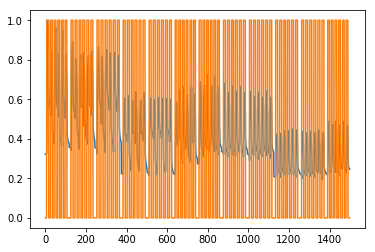

In [9]:
print surf[-1,-1,-1].shape, surfla[:,-1,-1].shape
plt.plot(surf[-1,-1,-1][:,0]/np.max(surf[-1,-1,-1][:,0],axis=0))
plt.hold
plt.plot(surfla[:,-1,-1])

In [10]:
print surf.shape

(4, 6, 3)


In [13]:
# Cross surface validation for 1 out of 6 surfaces

cv = KFold(n_splits=5,random_state=42)
scaler = StandardScaler() ;
decomp = PCA(n_components=20)
def filename(i,j,k,l):
    return 'fs_'+str(i)+'_subfs_'+str(j)+'_tr_'+str(k)+'_ts_'+str(l)

def cross_fit(i,j,k,l,data,labels,data2,labels2,pipe):
    fileid = 'tmpresults1_transtart/'+filename(i,j,k,l)+'.npz'
    if not os.path.isfile(fileid):
        print i,j,k,l
        if k==l: # perform K-fold                  
#             data = surf[j][k][i][::100,:]
#             labels = surfla[k][i][::100]
            folds = cv.split(data, labels)
            cm_all = np.zeros((2,2))
            for fold, (train_ind, test_ind) in enumerate(folds):
                x_train, x_test = data[train_ind], data[test_ind]
                y_train, y_test = labels[train_ind], labels[test_ind]
                model = pipe.fit(x_train,y_train)
                y_pred = model.predict(x_test)
                cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                cm_all += cm/5.
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
#             tr_data = surf[j][k][i]
#             tr_labels = surfla[k][i]
#             ts_data = surf[j][l][i]
#             ts_labels = surfla[l][i]
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            print 'Fitting on '+str(k)+', testing on '+str(l)+'...'
            model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps(i,j,jmax,surf,surfla):
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k in range(surf.shape[0]): # for every training surface
        for l in range(surf.shape[0]): # for every testing surface
#             cross_fit(i,j,k,l,surf[k][::100,:],surfla[k][::100],surf[l][::100,:],surfla[l][::100],pipe)
            cross_fit(i,j,k,l,surf[k],surfla[:,k],surf[l],surfla[:,l],pipe)

# for i in range(surf.shape[2]): # for every featureset
for i in [2]:#range(1): # for every featureset
#     for j in range(surf.shape[0]): # for every subfeatureset
#         if j==surf.shape[0]-1:
#             featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
#         else:
#             featsel = SelectKBest(k='all',score_func= mutual_info_classif)
#         pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
#         init_steps(i,j,surf[j][:][i],surfla[:][i])
    # for every subfeatureset
    [Parallel(n_jobs=-1)([delayed(init_steps) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) for j in range(surf.shape[0])])]
#         for k in range(surf.shape[1]): # for every training surface
#             for l in range(surf.shape[1]): # for every testing surface
#                 cross_fit(i,j,k,l,surf,surfla,pipe)
#             [Parallel(n_jobs=-1)([delayed(cross_fit) (i,j,k,l,surf,surfla,pipe) for l in range(surf.shape[1])])]
            

2 0 0 0
2 1 0 0
2 2 0 0
2 3 0 0
2 0 0 1
Fitting on 0, testing on 1...
2 0 0 2
Fitting on 0, testing on 2...
2 0 0 3
Fitting on 0, testing on 3...
2 0 0 4
Fitting on 0, testing on 4...
2 2 0 1
Fitting on 0, testing on 1...
2 0 0 5
Fitting on 0, testing on 5...
2 0 1 0
Fitting on 1, testing on 0...
2 2 0 2
Fitting on 0, testing on 2...
2 0 1 1
2 2 0 3
Fitting on 0, testing on 3...
2 2 0 4
Fitting on 0, testing on 4...
2 0 1 2
Fitting on 1, testing on 2...
2 0 1 3
Fitting on 1, testing on 3...
2 1 0 1
Fitting on 0, testing on 1...
2 2 0 5
Fitting on 0, testing on 5...
2 0 1 4
Fitting on 1, testing on 4...
2 0 1 5
Fitting on 1, testing on 5...
2 2 1 0
Fitting on 1, testing on 0...
2 0 2 0
Fitting on 2, testing on 0...
2 0 2 1
Fitting on 2, testing on 1...
2 1 0 2
Fitting on 0, testing on 2...
2 2 1 1
2 0 2 2
2 1 0 3
Fitting on 0, testing on 3...
2 3 0 1
Fitting on 0, testing on 1...
2 0 2 3
Fitting on 2, testing on 3...
2 0 2 4
Fitting on 2, testing on 4...
2 0 2 5
Fitting on 2, testing on

In [14]:
## Cross surface validation for 2 out of 6 surfaces

cv = KFold(n_splits=5,random_state=42)
scaler = StandardScaler() ;
decomp = PCA(n_components=20)
def filename(i,j,k1,k2,l):
    return 'fs_'+str(i)+'_subfs_'+str(j)+'_tr1_'+str(k1)+'_tr2_'+str(k2)+'_ts_'+str(l)

def cross_fit(i,j,k1,k2,l,data,labels,data2,labels2,pipe):
    fileid = 'tmpresults2_transtart/'+filename(i,j,k1,k2,l)+'.npz'
    if not os.path.isfile(fileid):
        print i,j,k1,k2,l
        if k1==l or k2==l: # perform K-fold      
            print 'Fitting on '+str(k1)+"-"+str(k2)+', cross-validating on '+str(l)+'...'
            if l == k1: # copy if existent from the other sibling file
                tmpcopyfileid = 'tmpresults2_transtart/'+filename(i,j,k1,k2,k2)+'.npz'
            else:   # same as above
                tmpcopyfileid = 'tmpresults2_transtart/'+filename(i,j,k1,k2,k1)+'.npz'                
            if not os.path.isfile(tmpcopyfileid):
                folds = cv.split(data, labels)
                cm_all = np.zeros((2,2))
                for fold, (train_ind, test_ind) in enumerate(folds):
                    x_train, x_test = data[train_ind], data[test_ind]
                    y_train, y_test = labels[train_ind], labels[test_ind]
                    model = pipe.fit(x_train,y_train)
                    y_pred = model.predict(x_test)
                    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                    cm_all += cm/5.
            else:
                cm_all = np.load(tmpcopyfileid)['cm']
                model = np.load(tmpcopyfileid)['model'][0]
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            print 'Fitting on '+str(k1)+"-"+str(k2)+', testing on '+str(l)+'...'
            model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps(i,j,jmax,surf,surfla):
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k1 in range(surf.shape[0]): # for every training surface1
        for k2 in range(surf.shape[0]): # for every training surface2
            if k2 > k1:
                for l in range(surf.shape[0]): # for every testing surface
#                     if l != k1 and l != k2:
        #             cross_fit(i,j,k,l,surf[k][::100,:],surfla[k][::100],surf[l][::100,:],surfla[l][::100],pipe)
                    tr_surf, tr_surfla = np.concatenate((surf[k1],surf[k2]),axis=0), np.concatenate((surfla[:,k1],surfla[:,k2]),axis=0)
                    ts_surf, ts_surfla = surf[l], surfla[:,l]
        #                 print tr_surf.shape, tr_surfla.shape
                    cross_fit(i,j,k1,k2,l,tr_surf,tr_surfla,ts_surf,ts_surfla,pipe)

for i in range(surf.shape[2]): # for every featureset
#     for j in range(surf.shape[0]): # for every subfeatureset
#         if j==surf.shape[0]-1:
#             featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
#         else:
#             featsel = SelectKBest(k='all',score_func= mutual_info_classif)
#         pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
#         init_steps(i,j,surf[j][:][i],surfla[:][i])
    # for every subfeatureset
    [Parallel(n_jobs=-1)([delayed(init_steps) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) for j in range(surf.shape[0])])]
#         for k in range(surf.shape[1]): # for every training surface
#             for l in range(surf.shape[1]): # for every testing surface
#                 cross_fit(i,j,k,l,surf,surfla,pipe)
#             [Parallel(n_jobs=-1)([delayed(cross_fit) (i,j,k,l,surf,surfla,pipe) for l in range(surf.shape[1])])]

0 0 0 1 0
Fitting on 0-1, cross-validating on 0...
0 1 0 1 0
Fitting on 0-1, cross-validating on 0...
Fitting on 0-1, cross-validating on 0...
0 2 0 1 0
0 3 0 1 0
Fitting on 0-1, cross-validating on 0...
0 0 0 1 1
Fitting on 0-1, cross-validating on 1...
0 0 0 1 2
Fitting on 0-1, testing on 2...
0 0 0 1 3
Fitting on 0-1, testing on 3...
0 0 0 1 4
Fitting on 0-1, testing on 4...
0 0 0 1 5
Fitting on 0-1, testing on 5...
0 2 0 1 1
Fitting on 0-1, cross-validating on 1...
0 2 0 1 2
Fitting on 0-1, testing on 2...
0 0 0 2 0
Fitting on 0-2, cross-validating on 0...
0 2 0 1 3
Fitting on 0-1, testing on 3...
0 2 0 1 4
Fitting on 0-1, testing on 4...
0 0 0 2 1
Fitting on 0-2, testing on 1...
0 0 0 2 2
Fitting on 0-2, cross-validating on 2...
0 0 0 2 3
Fitting on 0-2, testing on 3...
0 2 0 1 5
Fitting on 0-1, testing on 5...
0 0 0 2 4
Fitting on 0-2, testing on 4...
0 0 0 2 5
Fitting on 0-2, testing on 5...
0 1 0 1 1
Fitting on 0-1, cross-validating on 1...
0 1 0 1 2
Fitting on 0-1, testing on 

0 3 0 3 5
Fitting on 0-3, testing on 5...
0 2 1 5 2
Fitting on 1-5, testing on 2...
0 3 0 4 0
Fitting on 0-4, cross-validating on 0...
0 2 1 5 3
Fitting on 1-5, testing on 3...
0 1 0 5 1
Fitting on 0-5, testing on 1...
0 2 1 5 4
Fitting on 1-5, testing on 4...
0 2 1 5 5
Fitting on 1-5, cross-validating on 5...
0 2 2 3 0
Fitting on 2-3, testing on 0...
0 1 0 5 2
Fitting on 0-5, testing on 2...
0 2 2 3 1
Fitting on 2-3, testing on 1...
0 2 2 3 2
Fitting on 2-3, cross-validating on 2...
0 1 0 5 3
Fitting on 0-5, testing on 3...
0 1 0 5 4
Fitting on 0-5, testing on 4...
0 2 2 3 3
Fitting on 2-3, cross-validating on 3...
0 2 2 3 4
Fitting on 2-3, testing on 4...
0 1 0 5 5
Fitting on 0-5, cross-validating on 5...
0 1 1 2 0
Fitting on 1-2, testing on 0...
0 2 2 3 5
Fitting on 2-3, testing on 5...
0 1 1 2 1
Fitting on 1-2, cross-validating on 1...
0 2 2 4 0
Fitting on 2-4, testing on 0...
0 2 2 4 1
Fitting on 2-4, testing on 1...
0 3 0 4 1
Fitting on 0-4, testing on 1...
0 2 2 4 2
Fitting on 2

1 0 0 1 1
Fitting on 0-1, cross-validating on 1...
1 0 0 1 2
Fitting on 0-1, testing on 2...


KeyboardInterrupt: 

In [15]:
## Cross surface validation for 3 out of 6 surfaces

cv = KFold(n_splits=5,random_state=42)
scaler = StandardScaler() ;
decomp = PCA(n_components=20)
def filename(i,j,k1,k2,k3,l):
    return 'fs_'+str(i)+'_subfs_'+str(j)+'_tr1_'+str(k1)+'_tr2_'+str(k2)+'_tr3_'+str(k3)+'_ts_'+str(l)

def cross_fit(i,j,k1,k2,k3,l,data,labels,data2,labels2,pipe):
    fileid = 'tmpresults3_transtart/'+filename(i,j,k1,k2,k3,l)+'.npz'
    if not os.path.isfile(fileid):
        print i,j,k1,k2,k3,l
        if k1==l or k2==l or k3==l: # perform K-fold      
            print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+', cross-validating on '+str(l)+'...'
            if l == k1: # copy if existent from the other sibling file
                tmpcopyfileid1 = 'tmpresults3_transtart/'+filename(i,j,k1,k2,k3,k2)+'.npz'
                tmpcopyfileid2 = 'tmpresults3_transtart/'+filename(i,j,k1,k2,k3,k3)+'.npz'
            elif l == k2:   # same as above
                tmpcopyfileid1 = 'tmpresults3_transtart/'+filename(i,j,k1,k2,k3,k1)+'.npz'
                tmpcopyfileid2 = 'tmpresults3_transtart/'+filename(i,j,k1,k2,k3,k3)+'.npz'
            else:
                tmpcopyfileid1 = 'tmpresults3_transtart/'+filename(i,j,k1,k2,k3,k1)+'.npz'
                tmpcopyfileid2 = 'tmpresults3_transtart/'+filename(i,j,k1,k2,k3,k2)+'.npz'
            if not os.path.isfile(tmpcopyfileid1) and not os.path.isfile(tmpcopyfileid2):
                folds = cv.split(data, labels)
                cm_all = np.zeros((2,2))
                for fold, (train_ind, test_ind) in enumerate(folds):
                    x_train, x_test = data[train_ind], data[test_ind]
                    y_train, y_test = labels[train_ind], labels[test_ind]
                    model = pipe.fit(x_train,y_train)
                    y_pred = model.predict(x_test)
                    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                    cm_all += cm/5.
            else:
                if os.path.isfile(tmpcopyfileid1):
                    cm_all = np.load(tmpcopyfileid1)['cm']
                    model = np.load(tmpcopyfileid1)['model'][0]
                else:
                    cm_all = np.load(tmpcopyfileid2)['cm']
                    model = np.load(tmpcopyfileid2)['model'][0]
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+', testing on '+str(l)+'...'
            model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps(i,j,jmax,surf,surfla):
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k1 in range(surf.shape[0]): # for every training surface1
        for k2 in range(surf.shape[0]): # for every training surface2
            if k2 > k1:
                for k3 in range(surf.shape[0]):
                    if k3 > k2:
                        for l in range(surf.shape[0]): # for every testing surface
        #                     if l != k1 and l != k2:
                #             cross_fit(i,j,k,l,surf[k][::100,:],surfla[k][::100],surf[l][::100,:],surfla[l][::100],pipe)
                            tr_surf, tr_surfla = np.concatenate((surf[k1],surf[k2],surf[k3]),axis=0), np.concatenate((surfla[:,k1],surfla[:,k2],surfla[:,k3]),axis=0)
                            ts_surf, ts_surfla = surf[l], surfla[:,l]
                #                 print tr_surf.shape, tr_surfla.shape
                            cross_fit(i,j,k1,k2,k3,l,tr_surf,tr_surfla,ts_surf,ts_surfla,pipe)

for i in range(surf.shape[2]): # for every featureset
#     for j in range(surf.shape[0]): # for every subfeatureset
#         if j==surf.shape[0]-1:
#             featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
#         else:
#             featsel = SelectKBest(k='all',score_func= mutual_info_classif)
#         pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
#         init_steps(i,j,surf[j][:][i],surfla[:][i])
    # for every subfeatureset
    [Parallel(n_jobs=-1)([delayed(init_steps) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) for j in range(surf.shape[0])])]

0 0 0 1 2 0
Fitting on 0-1-2, cross-validating on 0...
0 1 0 1 2 0
Fitting on 0-1-2, cross-validating on 0...
Fitting on 0-1-2, cross-validating on 0...
0 2 0 1 2 0
0 3 0 1 2 0
Fitting on 0-1-2, cross-validating on 0...
0 0 0 1 2 1
Fitting on 0-1-2, cross-validating on 1...
0 0 0 1 2 2
Fitting on 0-1-2, cross-validating on 2...
0 0 0 1 2 3
Fitting on 0-1-2, testing on 3...
0 0 0 1 2 4
Fitting on 0-1-2, testing on 4...
0 0 0 1 2 5
Fitting on 0-1-2, testing on 5...
0 0 0 1 3 0
Fitting on 0-1-3, cross-validating on 0...
0 2 0 1 2 1
Fitting on 0-1-2, cross-validating on 1...
0 2 0 1 2 2
Fitting on 0-1-2, cross-validating on 2...
0 2 0 1 2 3
Fitting on 0-1-2, testing on 3...
0 2 0 1 2 4
Fitting on 0-1-2, testing on 4...
0 0 0 1 3 1
Fitting on 0-1-3, cross-validating on 1...
0 0 0 1 3 2
Fitting on 0-1-3, testing on 2...
0 2 0 1 2 5
Fitting on 0-1-2, testing on 5...
0 0 0 1 3 3
Fitting on 0-1-3, cross-validating on 3...
0 0 0 1 3 4
Fitting on 0-1-3, testing on 4...
0 0 0 1 3 5
Fitting on 0-1-

Fitting on 1-3-5, cross-validating on 1...
0 1 0 1 5 3
Fitting on 0-1-5, testing on 3...
0 3 0 1 4 1
Fitting on 0-1-4, cross-validating on 1...
0 3 0 1 4 2
Fitting on 0-1-4, testing on 2...
0 0 1 3 5 2
Fitting on 1-3-5, testing on 2...
0 2 0 3 4 1
Fitting on 0-3-4, testing on 1...
0 1 0 1 5 4
Fitting on 0-1-5, testing on 4...
0 0 1 3 5 3
Fitting on 1-3-5, cross-validating on 3...
0 0 1 3 5 4
Fitting on 1-3-5, testing on 4...
0 0 1 3 5 5
Fitting on 1-3-5, cross-validating on 5...
0 0 1 4 5 0
Fitting on 1-4-5, testing on 0...
0 2 0 3 4 2
Fitting on 0-3-4, testing on 2...
0 0 1 4 5 1
Fitting on 1-4-5, cross-validating on 1...
0 2 0 3 4 3
Fitting on 0-3-4, cross-validating on 3...
0 2 0 3 4 4
Fitting on 0-3-4, cross-validating on 4...
0 2 0 3 4 5
Fitting on 0-3-4, testing on 5...
0 1 0 1 5 5
Fitting on 0-1-5, cross-validating on 5...
0 1 0 2 3 0
Fitting on 0-2-3, cross-validating on 0...
0 3 0 1 4 3
Fitting on 0-1-4, testing on 3...
0 2 0 3 5 0
Fitting on 0-3-5, cross-validating on 0...
0 

0 2 2 4 5 4
Fitting on 2-4-5, cross-validating on 4...
0 2 2 4 5 5
Fitting on 2-4-5, cross-validating on 5...
0 2 3 4 5 0
Fitting on 3-4-5, testing on 0...
0 1 0 4 5 2
Fitting on 0-4-5, testing on 2...
0 2 3 4 5 1
Fitting on 3-4-5, testing on 1...
0 3 0 2 5 1
Fitting on 0-2-5, testing on 1...
0 2 3 4 5 2
Fitting on 3-4-5, testing on 2...
0 1 0 4 5 3
Fitting on 0-4-5, testing on 3...
0 2 3 4 5 3
Fitting on 3-4-5, cross-validating on 3...
0 3 0 2 5 2
Fitting on 0-2-5, cross-validating on 2...
0 3 0 2 5 3
Fitting on 0-2-5, testing on 3...
0 1 0 4 5 4
Fitting on 0-4-5, cross-validating on 4...
0 1 0 4 5 5
Fitting on 0-4-5, cross-validating on 5...
0 1 1 2 3 0
Fitting on 1-2-3, testing on 0...
0 1 1 2 3 1
Fitting on 1-2-3, cross-validating on 1...
0 2 3 4 5 4
Fitting on 3-4-5, cross-validating on 4...
0 2 3 4 5 5
Fitting on 3-4-5, cross-validating on 5...
0 3 0 2 5 4
Fitting on 0-2-5, testing on 4...
0 3 0 2 5 5
Fitting on 0-2-5, cross-validating on 5...
0 3 0 3 4 0
Fitting on 0-3-4, cross-

1 0 0 1 2 4
Fitting on 0-1-2, testing on 4...
1 0 0 1 2 5
Fitting on 0-1-2, testing on 5...
1 0 0 1 3 0
Fitting on 0-1-3, cross-validating on 0...
1 2 0 1 2 1
Fitting on 0-1-2, cross-validating on 1...
1 2 0 1 2 2
Fitting on 0-1-2, cross-validating on 2...
1 2 0 1 2 3
Fitting on 0-1-2, testing on 3...
1 2 0 1 2 4
Fitting on 0-1-2, testing on 4...
1 0 0 1 3 1
Fitting on 0-1-3, cross-validating on 1...
1 0 0 1 3 2
Fitting on 0-1-3, testing on 2...
1 2 0 1 2 5
Fitting on 0-1-2, testing on 5...
1 0 0 1 3 3
Fitting on 0-1-3, cross-validating on 3...
1 0 0 1 3 4
Fitting on 0-1-3, testing on 4...
1 0 0 1 3 5
Fitting on 0-1-3, testing on 5...
1 2 0 1 3 0
Fitting on 0-1-3, cross-validating on 0...
1 0 0 1 4 0
Fitting on 0-1-4, cross-validating on 0...
1 1 0 1 2 1
Fitting on 0-1-2, cross-validating on 1...
1 1 0 1 2 2
Fitting on 0-1-2, cross-validating on 2...
1 1 0 1 2 3
Fitting on 0-1-2, testing on 3...
1 0 0 1 4 1
Fitting on 0-1-4, cross-validating on 1...
1 0 0 1 4 2
Fitting on 0-1-4, testin

KeyboardInterrupt: 

In [16]:
## Cross surface validation for 4 out of 6 surfaces

cv = KFold(n_splits=5,random_state=42)
scaler = StandardScaler() ;
decomp = PCA(n_components=20)
def filename(i,j,k1,k2,k3,k4,l):
    return 'fs_'+str(i)+'_subfs_'+str(j)+'_tr1_'+str(k1)+'_tr2_'+str(k2)+'_tr3_'+str(k3)+'_tr4_'+str(k4)+'_ts_'+str(l)

def cross_fit(i,j,k1,k2,k3,k4,l,data,labels,data2,labels2,pipe):
    fileid = 'tmpresults4_transtart/'+filename(i,j,k1,k2,k3,k4,l)+'.npz'
    if not os.path.isfile(fileid):
        print i,j,k1,k2,k3,k4,l
        if k1==l or k2==l or k3==l or k4==l: # perform K-fold      
            print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+"-"+str(k4)+', cross-validating on '+str(l)+'...'
            if l == k1: # copy if existent from the other sibling file
                tmpcopyfileid1 = 'tmpresults4_transtart/'+filename(i,j,k1,k2,k3,k4,k2)+'.npz'
                tmpcopyfileid2 = 'tmpresults4_transtart/'+filename(i,j,k1,k2,k3,k4,k3)+'.npz'
                tmpcopyfileid3 = 'tmpresults4_transtart/'+filename(i,j,k1,k2,k3,k4,k4)+'.npz'
            elif l == k2:   # same as above
                tmpcopyfileid1 = 'tmpresults4_transtart/'+filename(i,j,k1,k2,k3,k4,k1)+'.npz'
                tmpcopyfileid2 = 'tmpresults4_transtart/'+filename(i,j,k1,k2,k3,k4,k3)+'.npz'
                tmpcopyfileid3 = 'tmpresults4_transtart/'+filename(i,j,k1,k2,k3,k4,k4)+'.npz'
            elif l == k3:   # same as above
                tmpcopyfileid1 = 'tmpresults4_transtart/'+filename(i,j,k1,k2,k3,k4,k1)+'.npz'
                tmpcopyfileid2 = 'tmpresults4_transtart/'+filename(i,j,k1,k2,k3,k4,k2)+'.npz'
                tmpcopyfileid3 = 'tmpresults4_transtart/'+filename(i,j,k1,k2,k3,k4,k4)+'.npz'
            else:
                tmpcopyfileid1 = 'tmpresults4_transtart/'+filename(i,j,k1,k2,k3,k4,k1)+'.npz'
                tmpcopyfileid2 = 'tmpresults4_transtart/'+filename(i,j,k1,k2,k3,k4,k2)+'.npz'
                tmpcopyfileid3 = 'tmpresults4_transtart/'+filename(i,j,k1,k2,k3,k4,k3)+'.npz'
            if not os.path.isfile(tmpcopyfileid1) and not os.path.isfile(tmpcopyfileid2) and not os.path.isfile(tmpcopyfileid3):
                folds = cv.split(data, labels)
                cm_all = np.zeros((2,2))
                for fold, (train_ind, test_ind) in enumerate(folds):
                    x_train, x_test = data[train_ind], data[test_ind]
                    y_train, y_test = labels[train_ind], labels[test_ind]
                    model = pipe.fit(x_train,y_train)
                    y_pred = model.predict(x_test)
                    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                    cm_all += cm/5.
            else:
                if os.path.isfile(tmpcopyfileid1):
                    cm_all = np.load(tmpcopyfileid1)['cm']
                    model = np.load(tmpcopyfileid1)['model'][0]
                elif os.path.isfile(tmpcopyfileid2):
                    cm_all = np.load(tmpcopyfileid2)['cm']
                    model = np.load(tmpcopyfileid2)['model'][0]
                elif os.path.isfile(tmpcopyfileid3):
                    cm_all = np.load(tmpcopyfileid3)['cm']
                    model = np.load(tmpcopyfileid3)['model'][0]
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+"-"+str(k4)+', testing on '+str(l)+'...'
            model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps(i,j,jmax,surf,surfla):
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k1 in range(surf.shape[0]): # for every training surface1
        for k2 in range(surf.shape[0]): # for every training surface2
            if k2 > k1:
                for k3 in range(surf.shape[0]):
                    if k3 > k2:
                        for k4 in range(surf.shape[0]):
                            if k4 > k3:
                                for l in range(surf.shape[0]): # for every testing surface
        #                     if l != k1 and l != k2:
                #             cross_fit(i,j,k,l,surf[k][::100,:],surfla[k][::100],surf[l][::100,:],surfla[l][::100],pipe)
                                    tr_surf, tr_surfla = np.concatenate((surf[k1],surf[k2],surf[k3]),axis=0), np.concatenate((surfla[:,k1],surfla[:,k2],surfla[:,k3]),axis=0)
                                    ts_surf, ts_surfla = surf[l], surfla[:,l]
                #                 print tr_surf.shape, tr_surfla.shape
                                    cross_fit(i,j,k1,k2,k3,k4,l,tr_surf,tr_surfla,ts_surf,ts_surfla,pipe)

for i in [0]:#range(surf.shape[2]): # for every featureset
#     for j in range(surf.shape[0]): # for every subfeatureset
#         if j==surf.shape[0]-1:
#             featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
#         else:
#             featsel = SelectKBest(k='all',score_func= mutual_info_classif)
#         pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
#         init_steps(i,j,surf[j][:][i],surfla[:][i])
    # for every subfeatureset
    [Parallel(n_jobs=-1)([delayed(init_steps) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) for j in range(surf.shape[0])])]

0 0 0 1 2 3 0
Fitting on 0-1-2-3, cross-validating on 0...
0 1 0 1 2 3 0
Fitting on 0-1-2-3, cross-validating on 0...
Fitting on 0-1-2-3, cross-validating on 0...
0 2 0 1 2 3 0
0 3 0 1 2 3 0
Fitting on 0-1-2-3, cross-validating on 0...
0 0 0 1 2 3 1
Fitting on 0-1-2-3, cross-validating on 1...
0 0 0 1 2 3 2
Fitting on 0-1-2-3, cross-validating on 2...
0 0 0 1 2 3 3
Fitting on 0-1-2-3, cross-validating on 3...
0 0 0 1 2 3 4
Fitting on 0-1-2-3, testing on 4...
0 0 0 1 2 3 5
Fitting on 0-1-2-3, testing on 5...
0 0 0 1 2 4 0
Fitting on 0-1-2-4, cross-validating on 0...
0 2 0 1 2 3 1
Fitting on 0-1-2-3, cross-validating on 1...
0 2 0 1 2 3 2
Fitting on 0-1-2-3, cross-validating on 2...
0 2 0 1 2 3 3
Fitting on 0-1-2-3, cross-validating on 3...
0 2 0 1 2 3 4
Fitting on 0-1-2-3, testing on 4...
0 2 0 1 2 3 5
Fitting on 0-1-2-3, testing on 5...
0 0 0 1 2 4 1
Fitting on 0-1-2-4, cross-validating on 1...
0 0 0 1 2 4 2
Fitting on 0-1-2-4, cross-validating on 2...
0 0 0 1 2 4 3
Fitting on 0-1-2-4,

0 0 1 2 4 5 5
Fitting on 1-2-4-5, cross-validating on 5...
0 0 1 3 4 5 0
Fitting on 1-3-4-5, testing on 0...
0 0 1 3 4 5 1
Fitting on 1-3-4-5, cross-validating on 1...
0 2 0 2 3 4 2
Fitting on 0-2-3-4, cross-validating on 2...
0 2 0 2 3 4 3
Fitting on 0-2-3-4, cross-validating on 3...
0 2 0 2 3 4 4
Fitting on 0-2-3-4, cross-validating on 4...
0 2 0 2 3 4 5
Fitting on 0-2-3-4, testing on 5...
0 2 0 2 3 5 0
Fitting on 0-2-3-5, cross-validating on 0...
0 0 1 3 4 5 2
Fitting on 1-3-4-5, testing on 2...
0 1 0 1 3 4 1
Fitting on 0-1-3-4, cross-validating on 1...
0 1 0 1 3 4 2
Fitting on 0-1-3-4, testing on 2...
0 0 1 3 4 5 3
Fitting on 1-3-4-5, cross-validating on 3...
0 0 1 3 4 5 4
Fitting on 1-3-4-5, cross-validating on 4...
0 0 1 3 4 5 5
Fitting on 1-3-4-5, cross-validating on 5...
0 0 2 3 4 5 0
Fitting on 2-3-4-5, testing on 0...
0 0 2 3 4 5 1
Fitting on 2-3-4-5, testing on 1...
0 0 2 3 4 5 2
Fitting on 2-3-4-5, cross-validating on 2...
0 1 0 1 3 4 3
Fitting on 0-1-3-4, cross-validating 

0 3 0 2 3 5 4
Fitting on 0-2-3-5, testing on 4...
0 1 1 2 3 5 2
Fitting on 1-2-3-5, cross-validating on 2...
0 1 1 2 3 5 3
Fitting on 1-2-3-5, cross-validating on 3...
0 1 1 2 3 5 4
Fitting on 1-2-3-5, testing on 4...
0 1 1 2 3 5 5
Fitting on 1-2-3-5, cross-validating on 5...
0 1 1 2 4 5 0
Fitting on 1-2-4-5, testing on 0...
0 3 0 2 3 5 5
Fitting on 0-2-3-5, cross-validating on 5...
0 3 0 2 4 5 0
Fitting on 0-2-4-5, cross-validating on 0...
0 1 1 2 4 5 1
Fitting on 1-2-4-5, cross-validating on 1...
0 1 1 2 4 5 2
Fitting on 1-2-4-5, cross-validating on 2...
0 1 1 2 4 5 3
Fitting on 1-2-4-5, testing on 3...
0 1 1 2 4 5 4
Fitting on 1-2-4-5, cross-validating on 4...
0 1 1 2 4 5 5
Fitting on 1-2-4-5, cross-validating on 5...
0 1 1 3 4 5 0
Fitting on 1-3-4-5, testing on 0...
0 3 0 2 4 5 1
Fitting on 0-2-4-5, testing on 1...
0 1 1 3 4 5 1
Fitting on 1-3-4-5, cross-validating on 1...
0 3 0 2 4 5 2
Fitting on 0-2-4-5, cross-validating on 2...
0 3 0 2 4 5 3
Fitting on 0-2-4-5, testing on 3...
0

In [17]:
## Cross surface validation for 5 out of 6 surfaces, or leave one out

cv = KFold(n_splits=5,random_state=42)
scaler = StandardScaler() ;
decomp = PCA(n_components=20)
def filename(i,j,k1,k2,k3,k4,k5,l):
    return 'fs_'+str(i)+'_subfs_'+str(j)+'_tr1_'+str(k1)+'_tr2_'+str(k2)+'_tr3_'+str(k3)+'_tr4_'+str(k4)+'_tr5_'+str(k5)+'_ts_'+str(l)

def cross_fit(i,j,k1,k2,k3,k4,k5,l,data,labels,data2,labels2,pipe):
    fileid = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,l)+'.npz'
    if not os.path.isfile(fileid):
        print i,j,k1,k2,k3,k4,k5,l
        if k1==l or k2==l or k3==l or k4==l or k5==l: # perform K-fold      
            print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+"-"+str(k4)+"-"+str(k5)+', cross-validating on '+str(l)+'...'
            if l == k1: # copy if existent from the other sibling file
                tmpcopyfileid1 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k2)+'.npz'
                tmpcopyfileid2 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k3)+'.npz'
                tmpcopyfileid3 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k4)+'.npz'
                tmpcopyfileid4 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k5)+'.npz'
            elif l == k2:   # same as above
                tmpcopyfileid1 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k1)+'.npz'
                tmpcopyfileid2 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k3)+'.npz'
                tmpcopyfileid3 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k4)+'.npz'
                tmpcopyfileid4 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k5)+'.npz'
            elif l == k3:   # same as above
                tmpcopyfileid1 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k1)+'.npz'
                tmpcopyfileid2 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k2)+'.npz'
                tmpcopyfileid3 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k4)+'.npz'
                tmpcopyfileid4 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k5)+'.npz'
            elif l == k4:   # same as above
                tmpcopyfileid1 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k1)+'.npz'
                tmpcopyfileid2 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k2)+'.npz'
                tmpcopyfileid3 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k3)+'.npz'
                tmpcopyfileid4 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k5)+'.npz'
            else:
                tmpcopyfileid1 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k1)+'.npz'
                tmpcopyfileid2 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k2)+'.npz'
                tmpcopyfileid3 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k3)+'.npz'
                tmpcopyfileid4 = 'tmpresults5_transtart/'+filename(i,j,k1,k2,k3,k4,k5,k4)+'.npz'
            if not os.path.isfile(tmpcopyfileid1) and not os.path.isfile(tmpcopyfileid2) and not os.path.isfile(tmpcopyfileid3) and not os.path.isfile(tmpcopyfileid4):
                folds = cv.split(data, labels)
                cm_all = np.zeros((2,2))
                for fold, (train_ind, test_ind) in enumerate(folds):
                    x_train, x_test = data[train_ind], data[test_ind]
                    y_train, y_test = labels[train_ind], labels[test_ind]
                    model = pipe.fit(x_train,y_train)
                    y_pred = model.predict(x_test)
                    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
                    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                    cm_all += cm/5.
            else:
                if os.path.isfile(tmpcopyfileid1):
                    cm_all = np.load(tmpcopyfileid1)['cm']
                    model = np.load(tmpcopyfileid1)['model'][0]
                elif os.path.isfile(tmpcopyfileid2):
                    cm_all = np.load(tmpcopyfileid2)['cm']
                    model = np.load(tmpcopyfileid2)['model'][0]
                elif os.path.isfile(tmpcopyfileid3):
                    cm_all = np.load(tmpcopyfileid3)['cm']
                    model = np.load(tmpcopyfileid3)['model'][0]
                elif os.path.isfile(tmpcopyfileid4):
                    cm_all = np.load(tmpcopyfileid4)['cm']
                    model = np.load(tmpcopyfileid4)['model'][0]
            np.savez(fileid,cm=cm_all,model=np.array([model]))
        else: # perform cross-check
            tr_data = data
            tr_labels = labels
            ts_data = data2
            ts_labels = labels2
            print 'Fitting on '+str(k1)+"-"+str(k2)+"-"+str(k3)+"-"+str(k4)+"-"+str(k5)+', testing on '+str(l)+'...'
            model = pipe.fit(tr_data,tr_labels)
            y_pred = model.predict(ts_data)
            cm = confusion_matrix(y_pred=y_pred, y_true=ts_labels)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            np.savez(fileid,cm=cm,model=np.array([model]))

def init_steps(i,j,jmax,surf,surfla):
    if j==jmax:
        featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
    else:
        featsel = SelectKBest(k='all',score_func= mutual_info_classif)
    pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
    for k1 in range(surf.shape[0]): # for every training surface1
        for k2 in range(surf.shape[0]): # for every training surface2
            if k2 > k1:
                for k3 in range(surf.shape[0]):
                    if k3 > k2:
                        for k4 in range(surf.shape[0]):
                            if k4 > k3:
                                for k5 in range(surf.shape[0]):
                                    if k5 > k4:
                                        for l in range(surf.shape[0]): # for every testing surface
        #                     if l != k1 and l != k2:
                #             cross_fit(i,j,k,l,surf[k][::100,:],surfla[k][::100],surf[l][::100,:],surfla[l][::100],pipe)
                                            tr_surf, tr_surfla = np.concatenate((surf[k1],surf[k2],surf[k3]),axis=0), np.concatenate((surfla[:,k1],surfla[:,k2],surfla[:,k3]),axis=0)
                                            ts_surf, ts_surfla = surf[l], surfla[:,l]
                #                 print tr_surf.shape, tr_surfla.shape
                                            cross_fit(i,j,k1,k2,k3,k4,k5,l,tr_surf,tr_surfla,ts_surf,ts_surfla,pipe)

for i in [0]:#range(surf.shape[2]): # for every featureset
#     for j in range(surf.shape[0]): # for every subfeatureset
#         if j==surf.shape[0]-1:
#             featsel = SelectKBest(k=1000,score_func= mutual_info_classif)
#         else:
#             featsel = SelectKBest(k='all',score_func= mutual_info_classif)
#         pipe = make_pipe_clf(scaler, featsel, decomp, classifiers[2])
#         init_steps(i,j,surf[j][:][i],surfla[:][i])
    # for every subfeatureset
    [Parallel(n_jobs=-1)([delayed(init_steps) (i,j,surf.shape[0]-1,surf[j,:,i],surfla[:,:,i]) for j in range(surf.shape[0])])]

0 0 0 1 2 3 4 0
Fitting on 0-1-2-3-4, cross-validating on 0...
0 1 0 1 2 3 4 0
Fitting on 0-1-2-3-4, cross-validating on 0...
Fitting on 0-1-2-3-4, cross-validating on 0...
0 2 0 1 2 3 4 0
0 3 0 1 2 3 4 0
Fitting on 0-1-2-3-4, cross-validating on 0...
0 0 0 1 2 3 4 1
Fitting on 0-1-2-3-4, cross-validating on 1...
0 0 0 1 2 3 4 2
Fitting on 0-1-2-3-4, cross-validating on 2...
0 0 0 1 2 3 4 3
Fitting on 0-1-2-3-4, cross-validating on 3...
0 0 0 1 2 3 4 4
Fitting on 0-1-2-3-4, cross-validating on 4...
0 0 0 1 2 3 4 5
Fitting on 0-1-2-3-4, testing on 5...
0 0 0 1 2 3 5 0
Fitting on 0-1-2-3-5, cross-validating on 0...
0 2 0 1 2 3 4 1
Fitting on 0-1-2-3-4, cross-validating on 1...
0 2 0 1 2 3 4 2
Fitting on 0-1-2-3-4, cross-validating on 2...
0 2 0 1 2 3 4 3
Fitting on 0-1-2-3-4, cross-validating on 3...
0 2 0 1 2 3 4 4
Fitting on 0-1-2-3-4, cross-validating on 4...
0 2 0 1 2 3 4 5
Fitting on 0-1-2-3-4, testing on 5...
0 0 0 1 2 3 5 1
Fitting on 0-1-2-3-5, cross-validating on 1...
0 0 0 1 2 

Fitting on 0-2-3-4-5, testing on 1...
0 3 0 2 3 4 5 2
Fitting on 0-2-3-4-5, cross-validating on 2...
0 3 0 2 3 4 5 3
Fitting on 0-2-3-4-5, cross-validating on 3...
0 3 0 2 3 4 5 4
Fitting on 0-2-3-4-5, cross-validating on 4...
0 3 0 2 3 4 5 5
Fitting on 0-2-3-4-5, cross-validating on 5...
0 3 1 2 3 4 5 0
Fitting on 1-2-3-4-5, testing on 0...
0 3 1 2 3 4 5 1
Fitting on 1-2-3-4-5, cross-validating on 1...
0 3 1 2 3 4 5 2
Fitting on 1-2-3-4-5, cross-validating on 2...
0 3 1 2 3 4 5 3
Fitting on 1-2-3-4-5, cross-validating on 3...
0 3 1 2 3 4 5 4
Fitting on 1-2-3-4-5, cross-validating on 4...
0 3 1 2 3 4 5 5
Fitting on 1-2-3-4-5, cross-validating on 5...
